In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
vistas_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_3_vistas.csv')
postulaciones_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_4_postulaciones.csv')
avisos_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
generos_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
educacion_raw = pd.read_csv('../data/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')

## Preguntas
* **Avisos con más postulaciones**
* **Relación vistas/postulaciones para un mismo aviso**
* **Distribución horaria de postulaciones**
* **Distribución postulaciones por día**
* **Distribución postulaciones por género**
* **Correlación usuario-postulaciones** - analizar si un mismo usuario se postula a avisos del mismo área o no

In [3]:
print(postulaciones_raw.info())
print('---------------------------------')
postulaciones_raw.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB
None
---------------------------------


,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34


**Limpieza y transformaciones**

In [4]:
postulaciones_raw.isna().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [5]:
postulaciones = postulaciones_raw.rename(columns={'fechapostulacion':'fecha'})

In [6]:
postulaciones['fecha'] = pd.to_datetime(postulaciones.fecha)

In [7]:
postulaciones.dtypes

idaviso                  int64
idpostulante            object
fecha           datetime64[ns]
dtype: object

In [8]:
postulaciones.shape

(3401623, 3)

**Análisis**

In [9]:
# TOP avisos con más postulaciones
data = pd.merge(postulaciones,avisos_raw[['idaviso','titulo','nombre_area']], on='idaviso')
print(data.isna().any())
data.head(1)

idaviso         False
idpostulante    False
fecha           False
titulo          False
nombre_area     False
dtype: bool


,idaviso,idpostulante,fecha,titulo,nombre_area
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,Atención al Cliente


In [10]:
top_post = data.idaviso.value_counts().reset_index().rename(columns={'idaviso':'count','index':'idaviso'})

In [11]:
data.idaviso.value_counts().head(3)

1112033906    9932
1112334791    9787
1112204682    9244
Name: idaviso, dtype: int64

In [12]:
top_post.head(3)

,idaviso,count
0,1112033906,9932
1,1112334791,9787
2,1112204682,9244


In [13]:
avisos_raw[avisos_raw.idaviso == 1112334791]

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
13003,1112334791,1,Cajero/a - Part Time,<p>Te estamos buscando para formar parte de un...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,Farmacity


In [14]:
seleccion = avisos_raw.idaviso.isin(top_post.idaviso)
top_post['titulo'] = avisos_raw.loc[seleccion,'titulo'].values
top_post['area'] = avisos_raw.loc[seleccion,'nombre_area'].values
top_post.head(3)

,idaviso,count,titulo,area
0,1112033906,9932,VENDEDOR/A PROVINCIA DE SANTA FE,Comercial
1,1112334791,9787,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,Transporte
2,1112204682,9244,Vendedor Viajante TUCUMAN/SANTIAGO DEL ESTERO,Ventas


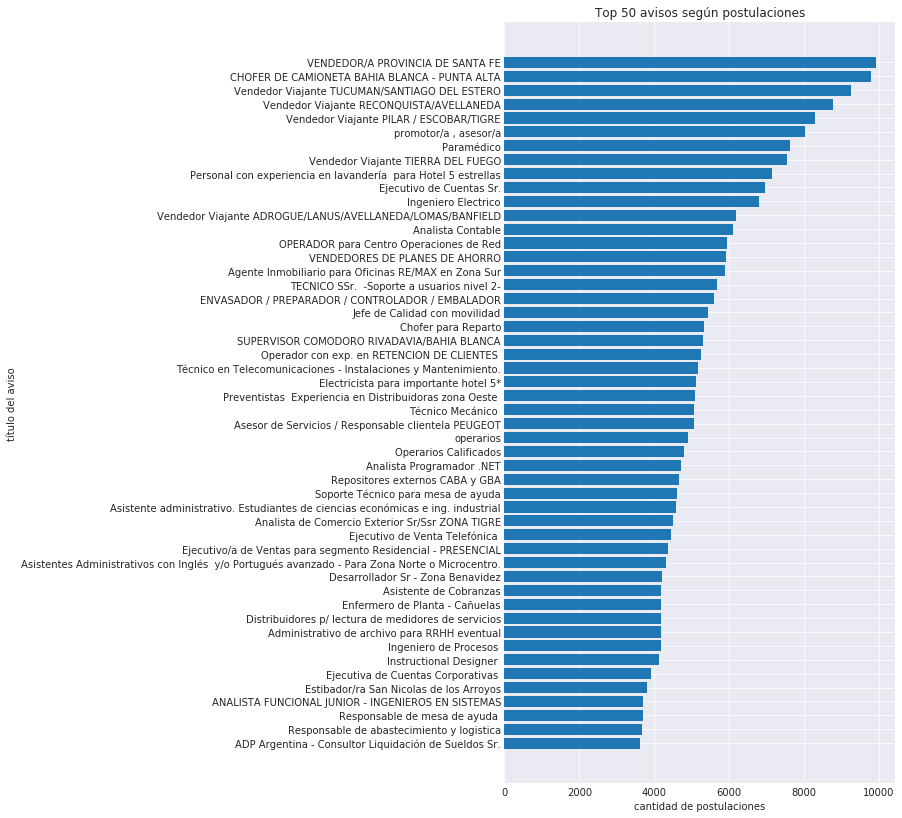

In [15]:
plot_data = top_post[['titulo','count']].head(50).iloc[::-1]
plt.figure(figsize=(7,14))
plt.title('Top 50 avisos según postulaciones')
plt.barh(plot_data['titulo'], plot_data['count'])
plt.xlabel('cantidad de postulaciones')
plt.ylabel('título del aviso')
plt.show()

### **Postulaciones segun nivel eductivo**
Analicemos como sonlas postulaciones según enl nivel educativo de los postulantes

In [16]:
data = postulaciones.merge(avisos_raw[['idaviso','titulo','nombre_area']], on='idaviso',how='left')\
                    .merge(educacion_raw, on='idpostulante',how='left')\
                    .merge(generos_raw,on='idpostulante',how='left')\
                    .rename(columns={'nombre_area':'area','nombre':'nivel_educ'})

In [17]:
print(data.info())
print(data.isna().any())
data.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5630562 entries, 0 to 5630561
Data columns (total 9 columns):
idaviso            int64
idpostulante       object
fecha              datetime64[ns]
titulo             object
area               object
nivel_educ         object
estado             object
fechanacimiento    object
sexo               object
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 429.6+ MB
None
idaviso            False
idpostulante       False
fecha              False
titulo              True
area                True
nivel_educ          True
estado              True
fechanacimiento     True
sexo               False
dtype: bool


,idaviso,idpostulante,fecha,titulo,area,nivel_educ,estado,fechanacimiento,sexo
0,1112257047,NM5M,2018-01-15 16:22:34,REPRESENTANTES DE ATENCIÓN AL CLIENTE/ RETENCIÓN,Atención al Cliente,Secundario,Graduado,1970-12-03,FEM


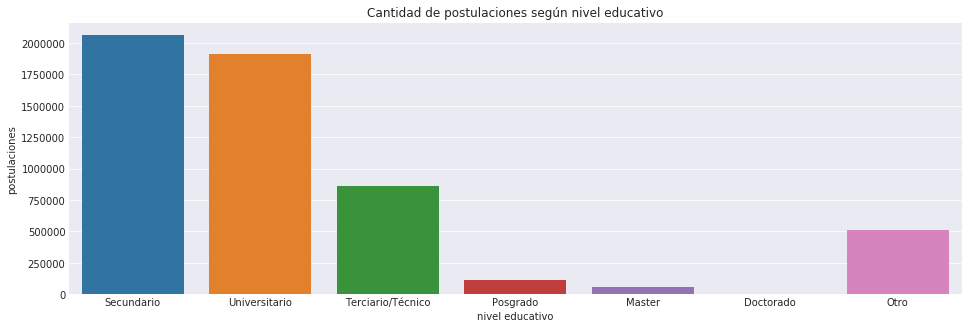

In [18]:
plt.figure(figsize=(16,5))
plt.title('Cantidad de postulaciones según nivel educativo')
sns.countplot(x=data['nivel_educ'],data=data)
plt.xlabel('nivel educativo')
plt.ylabel('postulaciones')
plt.show()

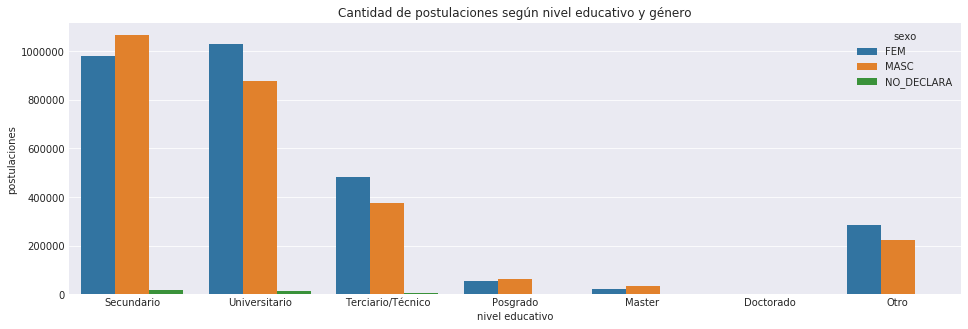

In [19]:
plt.figure(figsize=(16,5))
plt.title('Cantidad de postulaciones según nivel educativo y género')
sns.countplot(x=data['nivel_educ'],data=data, hue=data['sexo'])
plt.xlabel('nivel educativo')
plt.ylabel('postulaciones')
plt.show()

In [20]:
data_to_pivot = data
data_to_pivot['count'] = 1
data_pivoted = data_to_pivot[['nivel_educ','sexo','count']].groupby(['sexo','nivel_educ']).sum().pivot_table(values='count',index='sexo',columns='nivel_educ')
data_pivoted

nivel_educ,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
sexo,,,,,,,
FEM,2187,22644,284691,54066,978050,482151,1026251
MASC,1348,35658,221852,62435,1063165,376653,875845
NO_DECLARA,17,212,1674,423,19574,5660,14112


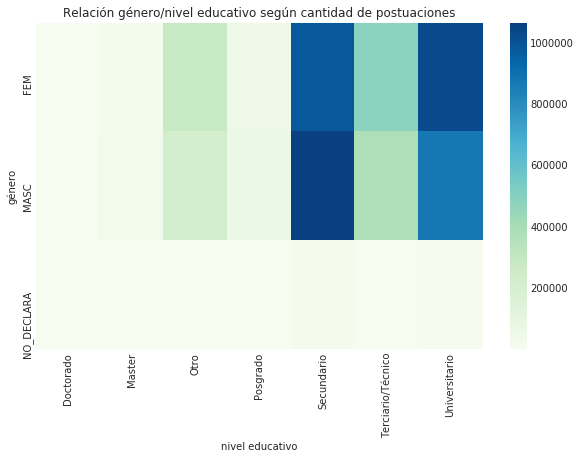

In [21]:
plt.figure(figsize=(10,6))
plt.title('Relación género/nivel educativo según cantidad de postuaciones')
sns.heatmap(data_pivoted, cmap='GnBu')
plt.xlabel('nivel educativo')
plt.ylabel('género')
plt.show()

### **Top áreas con más postulaciones**

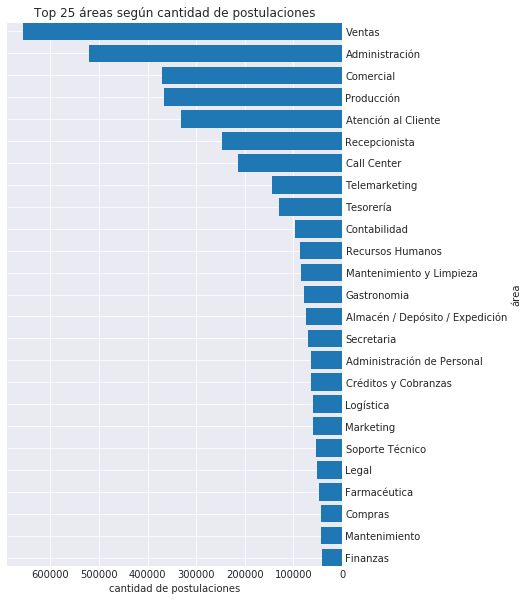

In [22]:
plot_data = data.area.value_counts().head(25).iloc[::-1]
plt.figure(figsize=(6,10))
plt.title('Top 25 áreas según cantidad de postulaciones')
plt.barh(plot_data.index,plot_data.values)
plt.xlabel('cantidad de postulaciones')
plt.ylabel('área')
plt.autoscale(tight=True, axis='y')
plt.gca().invert_xaxis()
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.show()

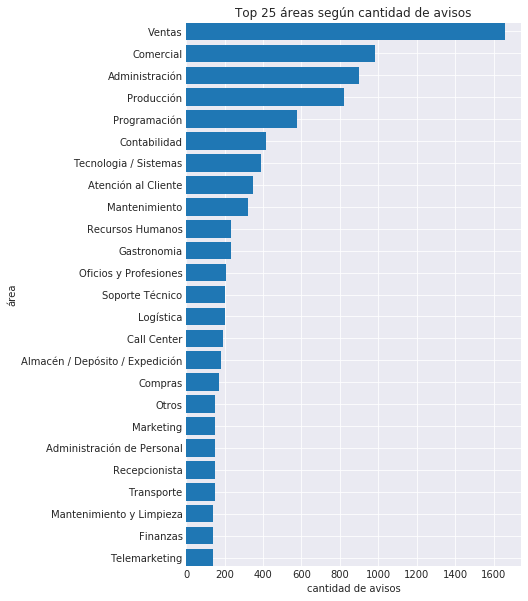

In [23]:
plot_data = avisos_raw.nombre_area.value_counts().head(25).iloc[::-1]
plt.figure(figsize=(6,10))
plt.title('Top 25 áreas según cantidad de avisos')
plt.barh(plot_data.index,plot_data.values)
plt.xlabel('cantidad de avisos')
plt.ylabel('área')
plt.autoscale(tight=True, axis='y')
#plt.gca().yaxis.tick_right()
#plt.gca().yaxis.set_label_position("right")
plt.show()

## **Relación vistas/postulaciones**

In [24]:
vistas_cont = vistas_raw.idAviso.value_counts().reset_index().rename(columns={'idAviso':'vistas','index':'idaviso'})
postulaciones_cont = postulaciones_raw.idaviso.value_counts().reset_index().rename(columns={'idaviso':'postulaciones','index':'idaviso'})

In [25]:
vistas_cont.head(1)

,idaviso,vistas
0,1112363488,4169


In [26]:
postulaciones_cont.head(1)

,idaviso,postulaciones
0,1112033906,9932


In [27]:
vistas_y_post = pd.merge(vistas_cont, postulaciones_cont, on='idaviso')
vistas_y_post.head(1)

,idaviso,vistas,postulaciones
0,1112363488,4169,1244


In [28]:
# Aproximación lineal por cuadrados mínimos
x = vistas_y_post['vistas']
y = vistas_y_post['postulaciones']
fit = np.polyfit(x, y, deg=1)
least_squares_aprox = fit[0] * x + fit[1]

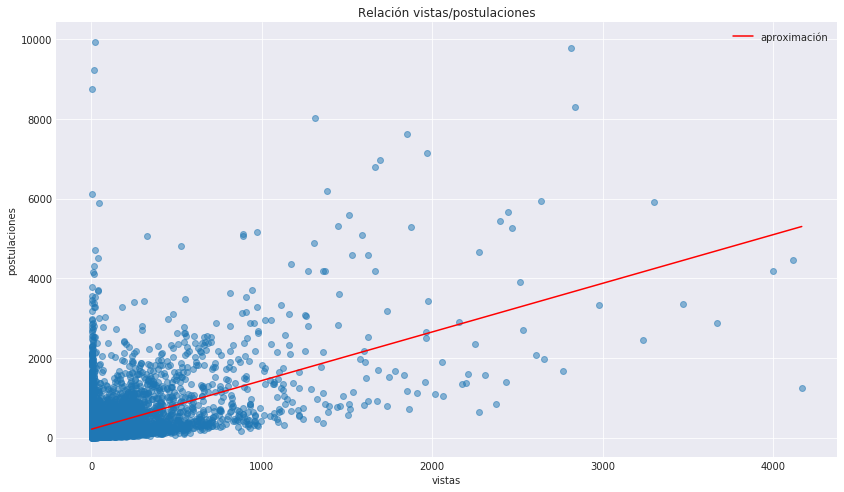

In [29]:
plt.figure(figsize=(14,8))
plt.title('Relación vistas/postulaciones')
plt.scatter(x=vistas_y_post.vistas,y=vistas_y_post.postulaciones, alpha=.5)
plt.plot(x, least_squares_aprox, color='red', label='aproximación')
plt.legend(['aproximación'])
plt.xlabel('vistas')
plt.ylabel('postulaciones')
plt.show()

In [30]:
vistas_y_post_filtered = vistas_y_post[vistas_y_post['vistas']<2000]
# Aproximación por cuadrados mínimos
x = vistas_y_post_filtered['vistas']
y = vistas_y_post_filtered['postulaciones']
fit = np.polyfit(x, y, deg=1)
least_squares_aprox = fit[0] * x + fit[1]

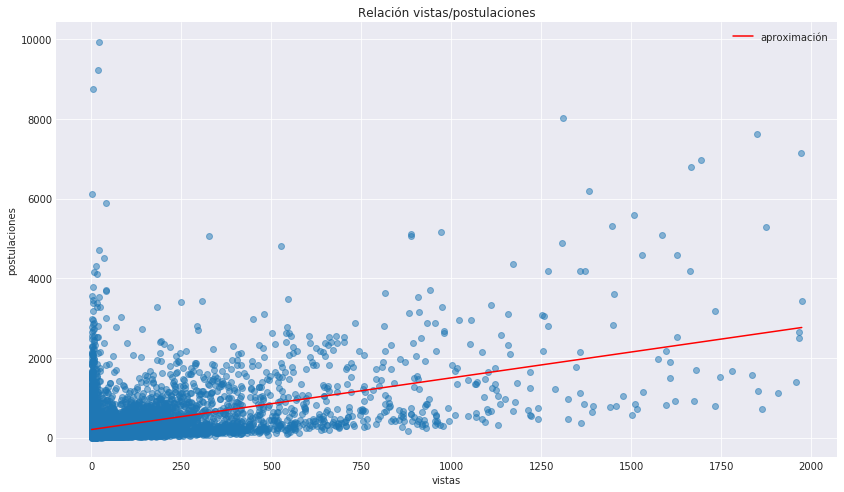

In [31]:
plt.figure(figsize=(14,8))
plt.title('Relación vistas/postulaciones')
plt.scatter(x=vistas_y_post_filtered.vistas,y=vistas_y_post_filtered.postulaciones, alpha=.5)
plt.plot(x, least_squares_aprox, color='red', label='aproximación')
plt.legend(['aproximación'])
plt.xlabel('vistas')
plt.ylabel('postulaciones')
plt.show()

## ** Postulaciones por usuario **

In [32]:
postulaciones.shape

(3401623, 3)

In [33]:
post_cont = postulaciones.idpostulante.value_counts()
print('Promedio de postulaciones por usuario:',post_cont.values.mean())
print('Cantidad máxima de postulaciones de un usuario:', post_cont.values.max())
print('Cantidad mínima de postulaciones de un usuario:', post_cont.values.min())

Promedio de postulaciones por usuario: 16.93293277846362
Cantidad máxima de postulaciones de un usuario: 3166
Cantidad mínima de postulaciones de un usuario: 1


In [34]:
post_cont.describe()

count    200888.000000
mean         16.932933
std          31.267385
min           1.000000
25%           3.000000
50%           8.000000
75%          19.000000
max        3166.000000
Name: idpostulante, dtype: float64

**Usuario con más postulaciones**

In [35]:
max_user_post = postulaciones.idpostulante.value_counts().head(1)
max_user_post

axmjOE    3166
Name: idpostulante, dtype: int64

In [36]:
postulaciones.idpostulante.value_counts().head(1).index

Index(['axmjOE'], dtype='object')

In [37]:
data = postulaciones.merge(avisos_raw, on='idaviso', how='inner').rename(columns={'nombre_area':'area'})

In [38]:
data.shape

(3074206, 13)

In [39]:
max_user_post_areas = data.loc[data.idpostulante == max_user_post.index[0],['area']].area.value_counts()

In [40]:
max_user_post_areas.sum()

2846

In [41]:
max_user_post_areas.describe()

count    140.000000
mean      20.328571
std       39.542063
min        1.000000
25%        3.000000
50%        8.000000
75%       19.000000
max      289.000000
Name: area, dtype: float64

In [42]:
print('Promedio de postulaciones por área:',max_user_post_areas.values.mean())

Promedio de postulaciones por área: 20.32857142857143


In [43]:
print('fecha inicial:', data.fecha.min())
print('fecha final:', data.fecha.max())
print('tiempo transcurrido: ',data.fecha.max()-data.fecha.min())

fecha inicial: 2018-01-15 00:00:01
fecha final: 2018-02-28 23:59:55
tiempo transcurrido:  44 days 23:59:54


In [44]:
print('primedio de postulaciones por día:',max_user_post_areas.sum()/44)

primedio de postulaciones por día: 64.68181818181819


In [45]:
#